# Species classification by whistles, Oswald data
# Expt 2: ENCOUNTER split;  cross-validation

# May  19, 2021

In [1]:
import numpy as np
from itertools import permutations
import random
import os
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd
from os import makedirs
from datetime import datetime
from collections import Counter

from math import floor

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# from MulticoreTSNE import MulticoreTSNE as TSNE
# from sklearn.manifold import TSNE
import seaborn as sns

from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Conv2D, Lambda, Flatten, MaxPooling2D, LSTM, ConvLSTM2D, GlobalAveragePooling2D, GlobalMaxPooling2D  # Reshape, Lambda, Concatenate
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras import backend as K

from tensorflow.keras.optimizers.schedules import ExponentialDecay, PiecewiseConstantDecay
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy  # CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
# import tensorflow_addons.layers.spatial_pyramid_pooling as spp
# import tensorflow_datasets as tfds
from tensorflow.math import l2_normalize

import tensorflow as tf

from lib_validation import DataGenerator, find_best_model
from lib_model import model_cnn14_spp, model_cnn14_attention_multi

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Hyper parameters

# 77.24 val for STAR2000
learning_rate = 1.e-4
conv_dim = 64
pool_size = 2
pool_stride = 2
l2_regu = 0.0001
drop_rate = 0.2
hidden_units = 512
fcn_dim = 512
run_num = 1  # [0, 1, 2, 3, ...]

# # A little bit l2
# learning_rate = 1.e-4
# conv_dim = 64
# pool_size = 2
# pool_stride = 2
# l2_regu = 0.0001  ==>> good, but need fine-tuning
# l2_regu = 0.001   ==>> too much!
# drop_rate = 0.2
# hidden_units = 512
# fcn_dim = 512

num_epoch = 200
# num_epoch = 1  # debug
# batch_size = 128
# batch_size = 32  # for cnn14+attention
batch_size = 16  # for cnn14+spp
copies_of_aug =  10

num_patience = 20

num_fold = 5

In [4]:
root_dir = '/home/ys587/__Data/__whistle'  # where we have __whislte_30_species folder
# root_dir = '/home/ubuntu'  # where we have __whislte_30_species folder

work_path = os.path.join(root_dir, '__whistle_30_species')
fit_result_path =  os.path.join(work_path, '__fit_result_species')
# feature_path = os.path.join(work_path, '__feature_species')
# feature_path = os.path.join(work_path, '__dataset/20210210')

In [21]:
species_dict = {'BD': 0, 'CD': 1, 'STR': 2, 'SPT': 3, 'SPIN': 4, 'PLT': 5, 'RT': 6,  'FKW': 7}
num_species = len(species_dict)
species_list = list(species_dict.keys())
species_id = list(species_dict.values())

## Features

In [6]:
feature_path = os.path.join(root_dir, '__whistle_30_species/__dataset/__feature')

In [7]:
# df_species = pd.read_csv(os.path.join(feature_path, 'all.csv'))
df_species = pd.read_csv(os.path.join(feature_path, 'all_species.csv'))
df_noise = pd.read_csv(os.path.join(feature_path, 'all_noise.csv'))

In [8]:
# generate data separated by encounters
# use species & encounter as keys!
species_label_list = []
encounter_unique = pd.unique(df_species['encounter'])
species_unique = []
for ee in encounter_unique:
    species_unique.append(df_species[df_species['encounter']==ee]['species'])
for ii in range(len(species_unique)):
    print(encounter_unique[ii])
    species_name = pd.unique(species_unique[ii])
    species_label_list.append(species_name[0])
# make an dataframe consisting of encounter_unique & species_label_list
df_encounter_species = pd.DataFrame({'encounter': encounter_unique, 'species': species_label_list})
# df_encounter_species.to_csv(os.path.join(dataset_path, 'encounter_species'+'.csv'), index=False)

HICEAS2002_s165
PICEAS2005_a101
PICEAS2005_a73
STAR2000_s352
STAR2000_s46
STAR2003_s494
STAR2003_s516
STAR2003_s586
STAR2000_s282
STAR2000_s302
STAR2000_s303
STAR2000_s313
STAR2000_s329
STAR2000_s338
STAR2000_s346
STAR2000_s368
STAR2000_s374
STAR2000_s375
STAR2000_s376
STAR2000_s377
STAR2000_s378
STAR2000_s48
STAR2000_s515
STAR2000_s561
STAR2003_s482
STAR2003_s489
STAR2003_s627
STAR2003_s628
STAR2003_s631
STAR2003_s640
STAR2003_s792
STAR2006_s216
PICEAS2005_a215
PICEAS2005_a245
PICEAS2005_a249
PICEAS2005_a250
PICEAS2005_a253
PICEAS2005_a57
PICEAS2005_a67
STAR2003_s776
STAR2006_s128
HICEAS2002_s219
HICEAS2002_s228
HICEAS2002_s261
HICEAS2002_s317
HICEAS2002_s318
PICEAS2005_a86
PICEAS2005_a93
STAR2000_s288
STAR2006_s142
STAR2006_s144
STAR2006_s145
STAR2006_s154
STAR2006_s156
STAR2006_s223
STAR2006_s230
HICEAS2002_s125
HICEAS2002_s167
HICEAS2002_s194
HICEAS2002_s234
HICEAS2002_s245
PICEAS2005_a178
PICEAS2005_a179
PICEAS2005_a23
PICEAS2005_a75
STAR2000_s417
STAR2006_s112
STAR2006_s153
HICEA

## Split over encounters

In [9]:
today = datetime.now()
# create a folder based on date & time
fit_result_path1 = os.path.join(fit_result_path, today.strftime('%Y%m%d_%H%M%S'))

In [10]:
label_pred_all = []
label_test_all = []

In [11]:
## fold split over encounters

In [12]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=num_fold)

In [ ]:
random_list0 = [0, 10, 20, 30, 40]
random_list = [rr+run_num for rr in random_list0]

In [13]:
# k-fold split
fold_id = 0
for train_set, test_set in skf.split(encounter_unique, species_label_list):
    print('Fold '+str(fold_id)+':')
    print('train_set')
    print(train_set)
    print('test_set')
    print(test_set)
    
    # (a) testing
    fea_ind_orig = []
    for tt in test_set:
        encounter_curr = df_encounter_species.iloc[tt]['encounter']
        # print(encounter_curr)
        df_species_test = df_species[(df_species['encounter'] == encounter_curr)]
        # print(list(df_species_test.index))
        fea_ind_orig += list(df_species_test.index)
        
    # loading
    fea_temp_orig = np.load(os.path.join(feature_path, 'all_orig.npz'))
    feas_orig = fea_temp_orig['feas_orig']
    labels_orig = fea_temp_orig['labels_orig']
    print('The shape of feas_orig: ', end='')
    print(feas_orig.shape)

    # original features & labels
    # fea_ind_orig = np.array(df_species_test.index)
    fea_test = feas_orig[fea_ind_orig, :, :]
    label_test = labels_orig[fea_ind_orig]
    label_test = np.array([species_dict[ll] for ll in label_test])
    print(fea_test.shape)
    
#     fea_ind_orig = np.array(fea_ind_orig)
#     # original features & labels
#     # fea_ind_orig = np.array(df_species_test.index)
#     fea_test = feas_orig[fea_ind_orig, :, :]
#     label_test = labels_orig[fea_ind_orig]
#     label_test = np.array([species_dict[ll] for ll in label_test])
#     print('')
#     print(len(test_set))
#     print(fea_test.shape)
#     print('')
    
    del feas_orig, labels_orig
    
    # (b) training
    fea_ind_orig0 = []
    fea_ind_aug = []
    for tt in train_set:
        encounter_curr = df_encounter_species.iloc[tt]['encounter']
        # print(encounter_curr)
        df_species_train = df_species[(df_species['encounter'] == encounter_curr)]
        # print(list(df_species_test.index))
        fea_ind_orig0 += list(df_species_train.index)

    # loading
    fea_temp_aug = np.load(os.path.join(feature_path, 'all_aug.npz'))
    feas_aug = fea_temp_aug['feas_aug']
    labels_aug = fea_temp_aug['labels_aug']
    print('The shape of feas_aug: ', end='')
    print(feas_aug.shape)
    
    # original features & labels
    #  fea_ind_orig = np.array(df_species_train.index)

    # augmented features & labels
    for ff in list(fea_ind_orig0):
        for ii in range(copies_of_aug):
            fea_ind_aug.append(ff*copies_of_aug+ii)
        
    fea_train = feas_aug[fea_ind_aug, :, :]
    label_train = labels_aug[fea_ind_aug]
    label_train = np.array([species_dict[ll] for ll in label_train])
    print(fea_train.shape)


#     fea_ind_aug = np.array(fea_ind_aug)
#     fea_train = feas_aug[fea_ind_aug, :, :]
#     label_train = labels_aug[fea_ind_aug]
#     label_train = np.array([species_dict[ll] for ll in label_train])
#     print('')
#     print(len(train_set))
#     print(fea_train.shape)
#     print('')
    
    del feas_aug, labels_aug
    
    # summary
    print('feature train shape: '+str(fea_train.shape))
    print('feature test shape: '+str(fea_test.shape))
    print('label train shape: '+str(label_train.shape))
    print('label test shape: '+str(label_test.shape))

    dim_time = fea_train.shape[1]
    dim_freq = fea_train.shape[2]
    print('dim_time: '+str(dim_time))
    print('dim_freq: '+str(dim_freq))
    
    # shuffle features & labels
    fea_train, label_train = shuffle(fea_train, label_train, random_state=random_list[fold_id])
    fea_test, label_test = shuffle(fea_test, label_test, random_state=random_list[fold_id])
    
    fea_train = np.expand_dims(fea_train, axis=3)
    fea_test = np.expand_dims(fea_test, axis=3)
    
    fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.10, random_state=random_list[fold_id])

    train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
    del fea_train
    validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
    del fea_validate
    
    # deployment folder
    fit_result_path2 = os.path.join(fit_result_path1, 'fold'+str(fold_id))
    if not os.path.exists(fit_result_path2):
        makedirs(fit_result_path2)
        
    # class weight
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

    class_weights = dict()
    for ii in range(num_species):
        class_weights[ii] = weights[ii]
        
    ### Training the model
    # model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
    model = model_cnn14_spp(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
    # loss = categorical_crossentropy
    loss = binary_crossentropy
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss, metrics=['accuracy'])
    # model.summary()

    # With classes
    # history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
    # history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
    # history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_loss", save_best_only=True)])
    # history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_accuracy", save_best_only=True)])
    history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_accuracy', mode='max', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_accuracy", save_best_only=True)])

    # Testing
    the_best_model, _ = find_best_model(fit_result_path2, purge=False)
    model = load_model(the_best_model)
    label_pred = model.predict(fea_test)

    # save the testing results
    np.savez(os.path.join(fit_result_path1, 'fold'+str(fold_id)+'_test_results.npz'), label_test=label_test, label_pred=label_pred)
    
    label_pred_all.append(label_pred)
    label_test_all.append(label_test)
    
    del train_generator, validate_generator
    
    fold_id += 1

Fold 0:
train_set
[  2   3   4   5   6   7  13  14  15  16  17  18  19  20  21  22  23  24
  25  26  27  28  29  30  31  34  35  36  37  38  39  40  44  45  46  47
  48  49  50  51  52  53  54  55  58  59  60  61  62  63  64  65  66  67
  70  71  72  73  74  75  76  77  78  79  84  85  86  87  88  89  90  91
  92  93  94  95  96  97 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130]
test_set
[  0   1   8   9  10  11  12  32  33  41  42  43  56  57  68  69  80  81
  82  83  98  99 100 101 102 103 104]
The shape of feas_orig: (20074, 101, 128)
(5040, 101, 128)
The shape of feas_aug: (200740, 101, 128)
(150340, 101, 128)
feature train shape: (150340, 101, 128)
feature test shape: (5040, 101, 128)
label train shape: (150340,)
label test shape: (5040,)
dim_time: 101
dim_freq: 128
Epoch 1/200
8456/8456 [==============================] - ETA: 0s - loss: 0.4916 - accuracy: 0.2975
Epoch 00001: val_accuracy improved from -inf to 0.43098, sav

In [14]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 101, 128, 1)]     0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 101, 128, 64)      640       
_________________________________________________________________
batch_normalization_52 (Batc (None, 101, 128, 64)      256       
_________________________________________________________________
activation_52 (Activation)   (None, 101, 128, 64)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 101, 128, 64)      36928     
_________________________________________________________________
batch_normalization_53 (Batc (None, 101, 128, 64)      256       
_________________________________________________________________
activation_53 (Activation)   (None, 101, 128, 64)      0   

In [15]:
label_pred_all = np.concatenate(label_pred_all)
label_test_all = np.concatenate(label_test_all)

In [16]:
label_test_all.shape

(20074,)

## Confusion matrix

In [17]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [22]:
print("Confusion matrix:")
# cm = confusion_matrix(label_train[:label_train_pred.shape[0]], np.argmax(label_train_pred, axis=1), labels=species_id)
cm = confusion_matrix(label_test_all, np.argmax(label_pred_all, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[1002  218  307  166  209  135   65   58]
 [  64 3364  701  261   73  115   58   79]
 [ 166  802 1130  166  131  146   64   86]
 [ 351 1002  363  364  131  134   23   24]
 [ 255  335  148   76  186   13   84   26]
 [ 150   95  116   29   14 1429   71  260]
 [  69   46   34    7   53   73  753  369]
 [  75  154   54   10   24  541  592 1975]]

[[0.46 0.1  0.14 0.08 0.1  0.06 0.03 0.03]
 [0.01 0.71 0.15 0.06 0.02 0.02 0.01 0.02]
 [0.06 0.3  0.42 0.06 0.05 0.05 0.02 0.03]
 [0.15 0.42 0.15 0.15 0.05 0.06 0.01 0.01]
 [0.23 0.3  0.13 0.07 0.17 0.01 0.07 0.02]
 [0.07 0.04 0.05 0.01 0.01 0.66 0.03 0.12]
 [0.05 0.03 0.02 0.   0.04 0.05 0.54 0.26]
 [0.02 0.04 0.02 0.   0.01 0.16 0.17 0.58]]


In [23]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

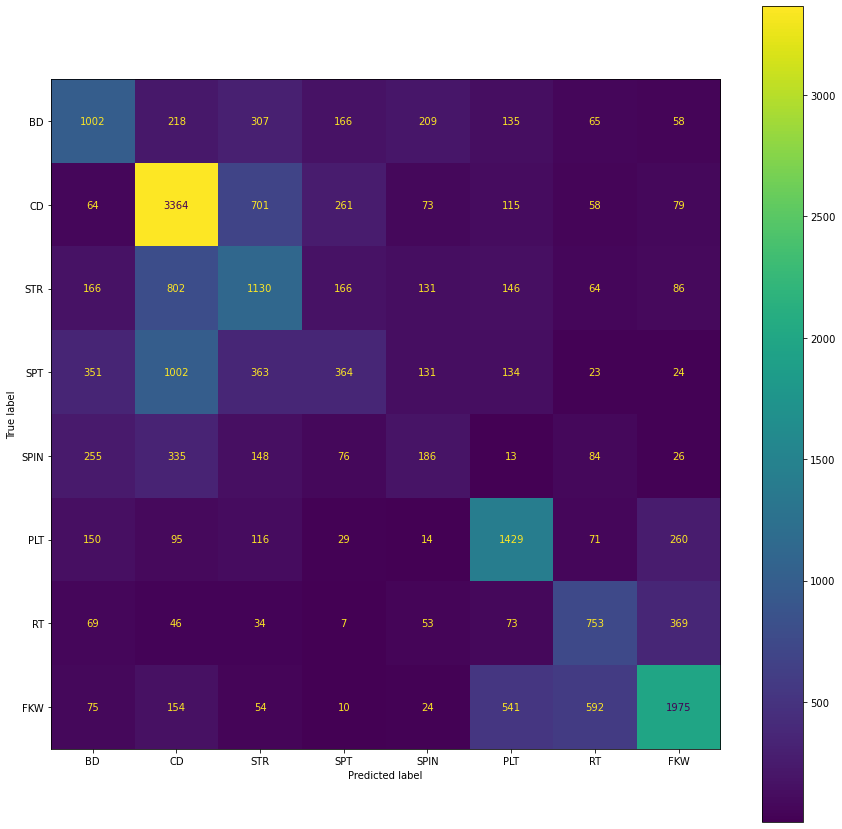

In [24]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


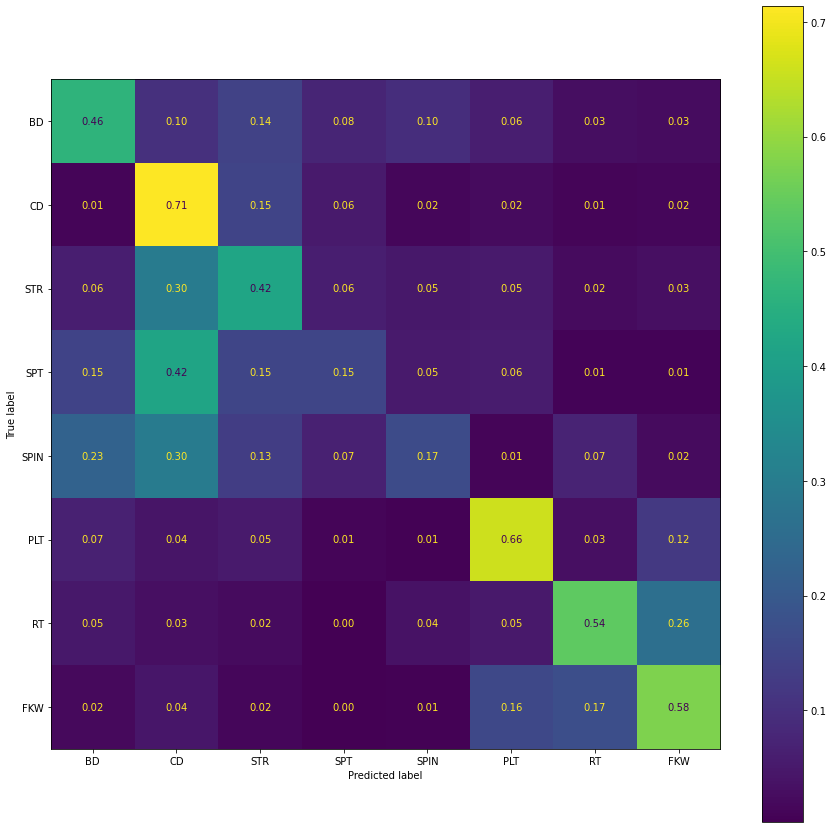

In [25]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)